In [ ]:
!pip install xmltodict
!pip install -U segmentation-models

     |████████████████████████████████| 50 kB 7.0 MB/s 


In [ ]:
import xmltodict
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image, ImageDraw
from PIL import ImagePath 
import numpy as np
import struct
import binascii
import os
from collections import Counter
from tqdm import tqdm
import pandas as pd
import json
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, LSTM, BatchNormalization, ReLU, Reshape
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from sklearn.model_selection import train_test_split

config = ConfigProto()
config.gpu_options.allow_growth = True

In [ ]:
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization,UpSampling2D
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [ ]:
!gdown --id "1HZY2Q6_weEOXesvAW2STCk6qEtEjyfTY"
!gdown --id "1UYvCJqQhJz1ps8b2QxyWTvBxc_JOr9uz"
!unzip -qq marmot_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1HZY2Q6_weEOXesvAW2STCk6qEtEjyfTY
To: /content/marmot_dataset.zip
123MB [00:01, 76.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UYvCJqQhJz1ps8b2QxyWTvBxc_JOr9uz
To: /content/CS2_Table_50_0030.hdf5
83.4MB [00:01, 54.9MB/s]


In [ ]:
!nvidia-smi

Sat Aug 21 09:10:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Process Dataset


- We have manually combined the files in Marmots and Extended Marmots dataset and saved them into a final_dataset
- final_dataset folder contains 3 folders
 1. **table_data** : contains xml files which contain table bounding boxes. Taken from original Marmots dataset
 2. **col_data** : contains xml files which contain table bounding boxes. Taken from original Extended Marmots dataset
 3. **images**
- We will use these images and create column and image masks and store them in folders

In [ ]:
def hex_to_float(BBox):
  '''
  Input : List of hex numbers
  Output : List of integers
  Objective : Convert hex to int format
  '''
  conv_pound = [struct.unpack('!d', bytes.fromhex(t))[0] for t in BBox]
  res = [round((float(x)/72)*96) for x in conv_pound]
  return res

In [ ]:
img_paths = set(os.listdir("final_dataset/images"))
table_data_paths = set(os.listdir("final_dataset/table_data"))
col_data_paths = set(os.listdir("final_dataset/col_data"))

def get_image_dim(image_id):
  img = cv2.imread("final_dataset/images/"+image_id+".bmp")
  return (img.shape[0],img.shape[1])

def extract_col_mask(file_name,height=None,width=None):
  '''
  Input: file_name -> image_id without extension, dimensions of image
  Output: column_mask, list_of_bounding_boxes
  Objective: Read xml file and generate column masks. 
        If xml file not found, return blank mask
  '''

  if file_name+".xml" not in col_data_paths:
    return np.array(Image.new("L", (width,height))),[None]

  res = {}
  list_of_bounding_boxes = []
  try:
    with open("final_dataset/col_data/"+file_name+".xml","r") as f:
      res= xmltodict.parse(f.read())
  except:
      column_mask = np.array(Image.new("L", (height,width)))
      return column_mask

  ht = int(res["annotation"]["size"]["height"])
  wt = int(res["annotation"]["size"]["width"])
  column_mask = np.array(Image.new("L", (wt,ht))) # Image.new("",(width, height))
  for bbox in res["annotation"]["object"]:
    bbox = dict(bbox["bndbox"])
    list_of_bounding_boxes.append(dict(bbox))
    start_point = (int(bbox["xmin"]),int(bbox["ymin"]))
    end_point = (int(bbox["xmax"]),int(bbox["ymax"]))
    column_mask = cv2.rectangle(column_mask, start_point, end_point,(255,255,255),-1)

  return column_mask, list_of_bounding_boxes

- To extract the bounding boxes from the table mask in the marmots dataset. First we need to convert the hex numbers into integers first.
- The bonuding box attributes as relative to the CropBox and not the actual image. Marmots dataset first defines a CropBox which represents a the content area. The bounding boxes have attributes which are relative to this crop Box
- First we extract the CropBox cordinates and then we scale the bounding box cordinates so as to fit the actual page cordinates.
- Also we need to transfrom the bonuding box formats
 ![](https://drive.google.com/uc?export=view&id=1v--SlHMhXX3peM2-RkS1ZX3hRyjvzeRj)
 
- **Reference** : https://stackoverflow.com/questions/52824584/do-anyone-know-how-to-extract-image-coordinate-from-marmot-dataset/53377650
. This contains the code to convert from hex <-> int and also scaling the imaegs

In [ ]:
# Ref : https://stackoverflow.com/questions/52824584/do-anyone-know-how-to-extract-image-coordinate-from-marmot-dataset/53377650
def extract_table_mask(file_name, height=None, width=None):
  '''
  Input: file_name -> image_id without extension, dimensions of image
  Output: column_mask, list_of_bounding_boxes
  Objective: Read xml file and generate column masks. 
        If xml file not found, return blank mask
  '''
  if file_name+".xml" not in table_data_paths:
    return np.array(Image.new("L", (width,height))),[None]

  res = {}
  with open("/content/final_dataset/table_data/"+file_name+".xml") as f:
    res= xmltodict.parse(f.read())
  
  table_bboxes = []
  imgw = width
  imgh = height
  table_mask = np.array(Image.new("L", (imgw,imgh)))

  px0, py1, px1, py0 = hex_to_float(res["Page"]["@CropBox"].split())
  pw = abs(px1 - px0)
  ph = abs(py1 - py0)
  try:
    test = res["Page"]["Contents"]["Composites"]
  except:
    print(file_name)
    print(res)

  for box in res["Page"]["Contents"]["Composites"]:
    if box['@Label'] == 'TableBody':    
      # if one table then box is OrderedDict else its a list of OrderedDict
      if isinstance(box["Composite"], list):
        bboxes = box["Composite"]
      else:
        bboxes = [box["Composite"]]
      for single_box in bboxes:
        cords = single_box["@BBox"].split()
        x0, y1, x1, y0 = hex_to_float(cords)
        x0 = round(imgw*(x0 - px0)/pw)
        x1 = round(imgw*(x1 - px0)/pw)
        y0 = round(imgh*(py1 - y0)/ph)
        y1 = round(imgh*(py1 - y1)/ph)

        table_bboxes.append({"xmin":x0,"ymin":y0,"xmax":x1,"ymax":y1})
        start_point = (x0,y0)
        end_point = (x1,y1)
        table_mask= cv2.rectangle(table_mask, start_point, end_point,(255,0,0),-1)
  

  return table_mask, table_bboxes

In [ ]:
data = {"id":[], "col_boxes":[],"data":[],"dimensions":[],"img_path":[],"col_mask_path":[],"table_mask_path":[]}

In [ ]:
# Iterate through all files and then extract the table and column masks and save then 
file_names = [x[:-4] for x in os.listdir("final_dataset/images")]
for name in tqdm(file_names, position=0,  leave=True):
  ht, wt = get_image_dim(name)
  column_mask, col_boxes = extract_col_mask(name, ht, wt)
  table_mask, table_bboxes = extract_table_mask(name, ht, wt)
  
  data["id"].append(name)
  data["col_boxes"].append(col_boxes)
  data["table_boxes"].append(table_bboxes)
  data["dimensions"].append({"height":ht, "width":wt})
  data["col_mask_path"].append("final_dataset/col_masks/"+name+".bmp")
  data["table_mask_path"].append("final_dataset/table_masks/"+name+".bmp")
  data["img_path"].append("final_dataset/images"+name+".bmp")

  0%|          | 0/532 [00:00<?, ?it/s]


KeyError: ignored

In [ ]:
# Create a new dataframe with all the details extracted
df = pd.DataFrame(data)
df.to_csv("final_dataset/marmot.csv",index=None)

# df.to_csv("final_dataset/marmot.csv", index=None)
# !zip -r marmot_dataset.zip final_dataset/
# !cp "marmot_dataset.zip" "/content/drive/MyDrive/Datasets/CS2/"
# !cp marmot_dataset.zip "/content/drive/MyDrive/Datasets/CS2/"

ValueError: ignored

Final Dataset CSV file
- **id** : image id
- **col_boxes** : List of table bounding box cordinates
- **table_boxes** : List of table bounding box cordinates
- **dimensions** : width and height of image
- **img_path** : path to image
- **col_mask_path** : path to column masked image
- **table_mask_path** : path to table masked image

# EDA


In [ ]:
df = pd.read_csv('final_dataset/marmot.csv')
df = df.drop(columns=["Unnamed: 0"])
df.head(5)

,id,col_boxes,table_boxes,dimensions,img_path,col_mask_path,table_mask_path
0,10.1.1.160.686_7,"[{""xmin"": ""61"", ""ymin"": ""118"", ""xmax"": ""126"", ...","[{""xmin"": 64, ""ymin"": 247, ""xmax"": 625, ""ymax""...","{""height"": 957, ""width"": 720}",final_dataset/images10.1.1.160.686_7.bmp,final_dataset/col_masks/10.1.1.160.686_7.bmp,final_dataset/table_masks/10.1.1.160.686_7.bmp
1,10.1.1.7.2122_8,"[""""]",[],"{""height"": 1123, ""width"": 793}",final_dataset/images10.1.1.7.2122_8.bmp,final_dataset/col_masks/10.1.1.7.2122_8.bmp,final_dataset/table_masks/10.1.1.7.2122_8.bmp
2,10.1.1.6.2186_8,"[""""]",[],"{""height"": 1123, ""width"": 793}",final_dataset/images10.1.1.6.2186_8.bmp,final_dataset/col_masks/10.1.1.6.2186_8.bmp,final_dataset/table_masks/10.1.1.6.2186_8.bmp
3,10.1.1.7.2112_8,"[""""]",[],"{""height"": 1056, ""width"": 816}",final_dataset/images10.1.1.7.2112_8.bmp,final_dataset/col_masks/10.1.1.7.2112_8.bmp,final_dataset/table_masks/10.1.1.7.2112_8.bmp
4,10.1.1.6.2302_7,"[""""]",[],"{""height"": 1123, ""width"": 794}",final_dataset/images10.1.1.6.2302_7.bmp,final_dataset/col_masks/10.1.1.6.2302_7.bmp,final_dataset/table_masks/10.1.1.6.2302_7.bmp


### Plot some image and column masks

In [ ]:
def plot_images(image_id):
  fig, ax = plt.subplots(1,3,figsize=(22,22))
  ax[0].imshow(cv2.imread("final_dataset/images/"+image_id+".bmp"))
  ax[0].title.set_text("Original Image")
  ax[1].imshow(cv2.imread("final_dataset/col_masks/"+image_id+".bmp"))
  ax[1].title.set_text("Column Mask")
  ax[2].imshow(cv2.imread("final_dataset/table_masks/"+image_id+".bmp"))
  ax[2].title.set_text("Table Mask")
  plt.show()


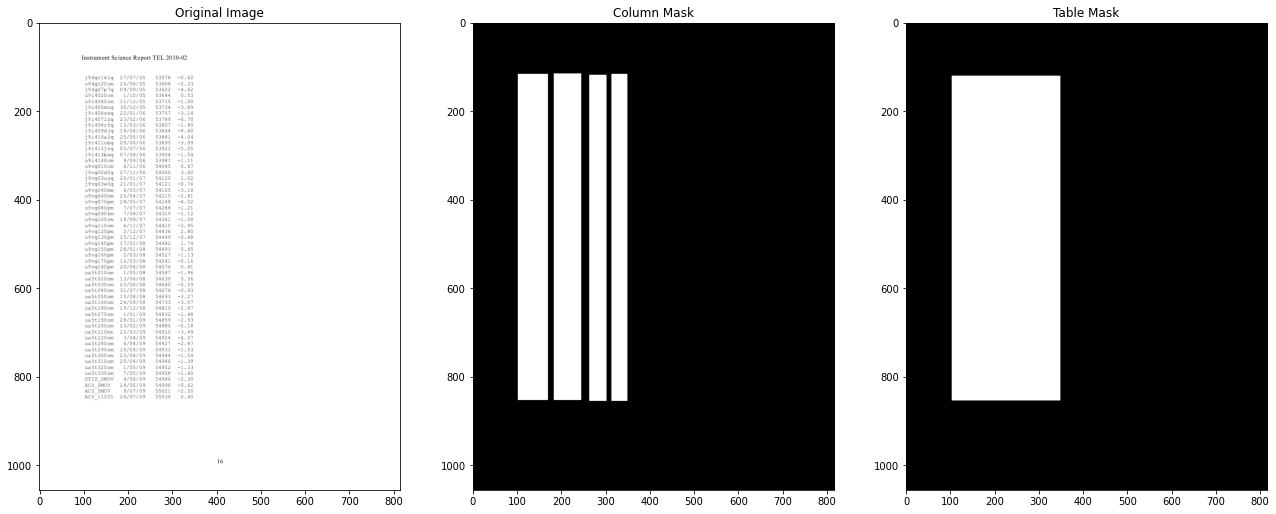

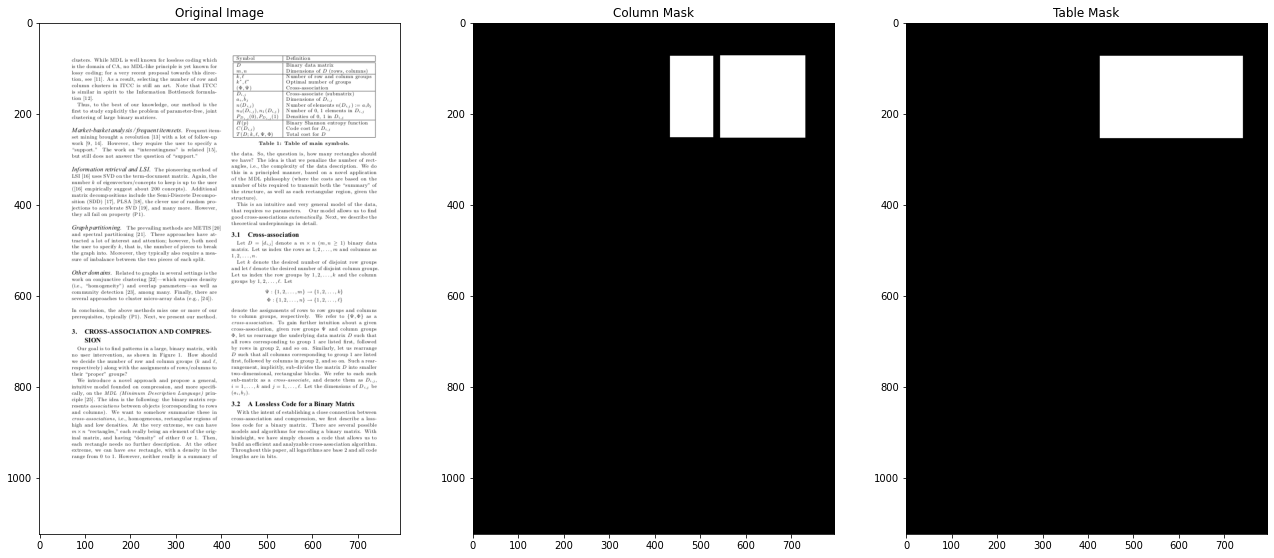

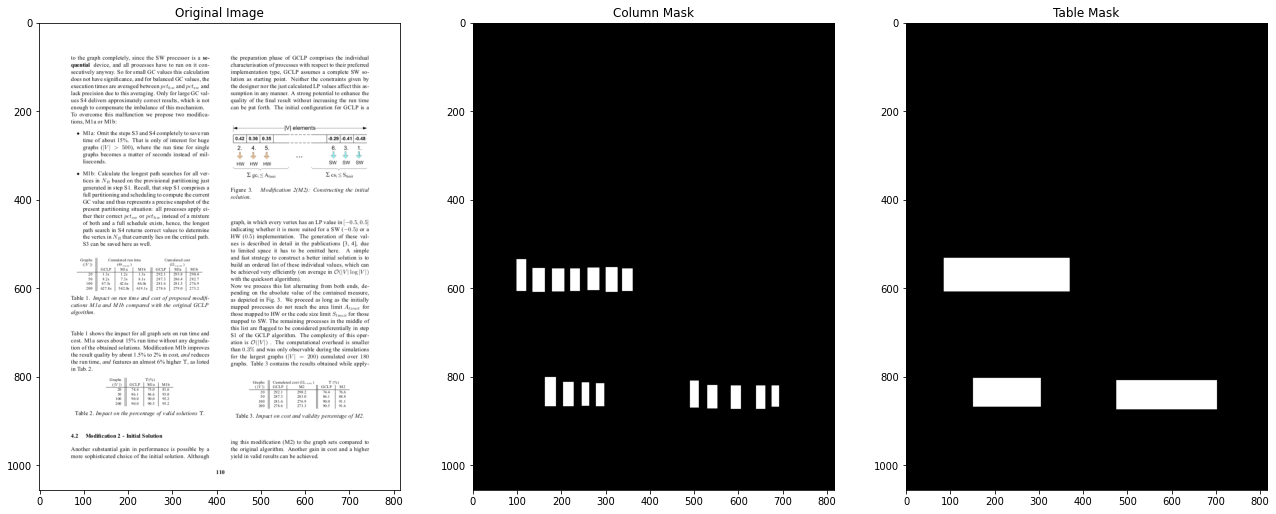

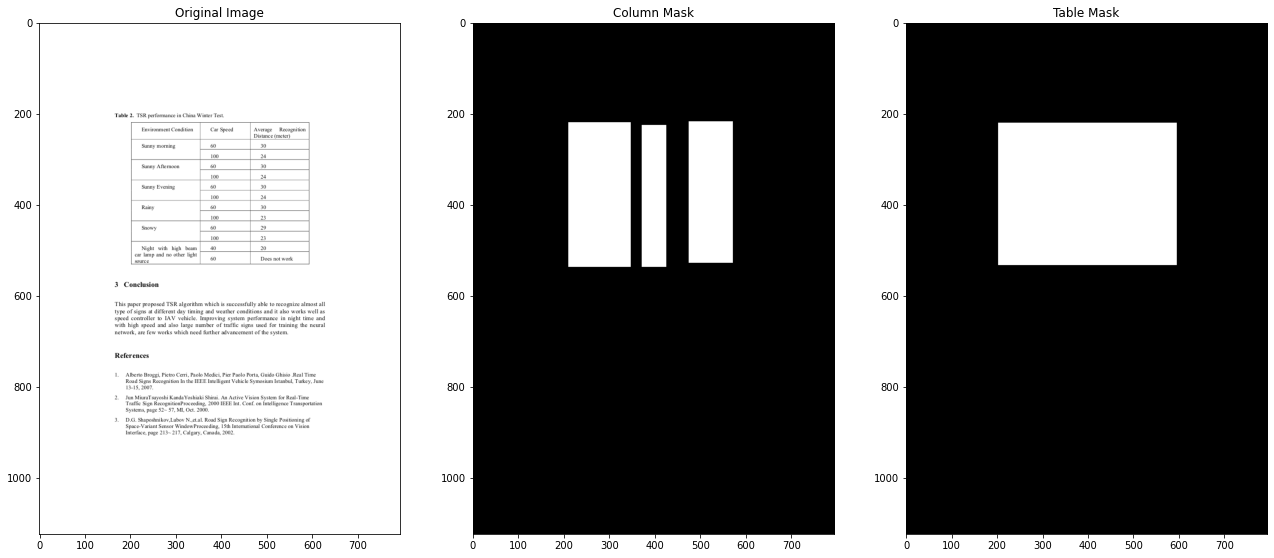

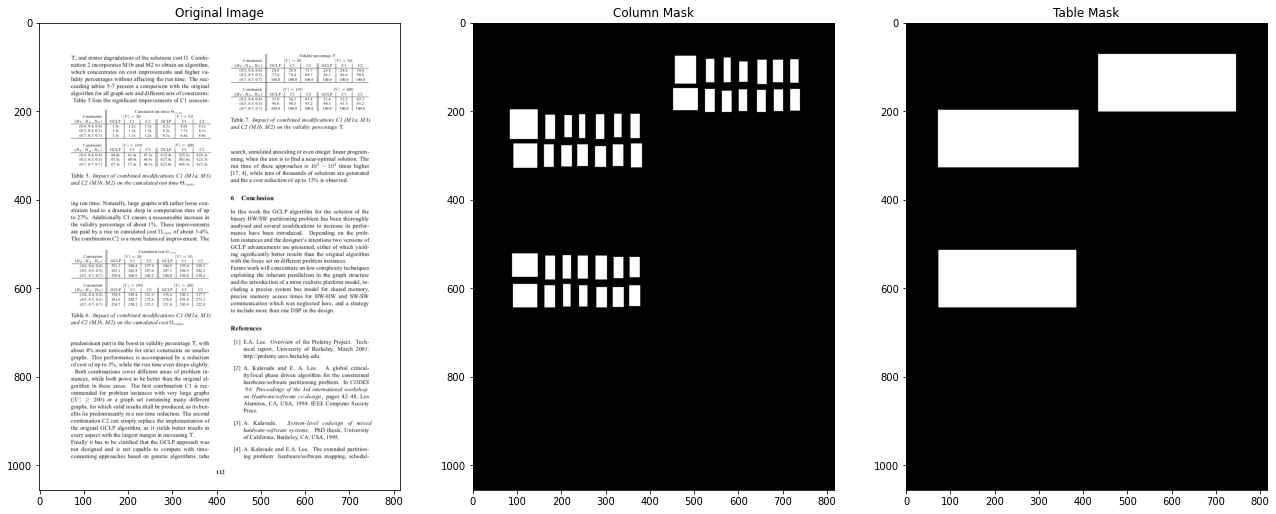

In [ ]:
for id in df.iloc[[50,56,150,311,500]]["id"].values:
  plot_images(id)

### Image widths and heights

In [ ]:
heights = []
widths = []

for dim in df["dimensions"]:
  dim = json.loads(dim)
  heights.append(dim["height"])
  widths.append(dim["width"])

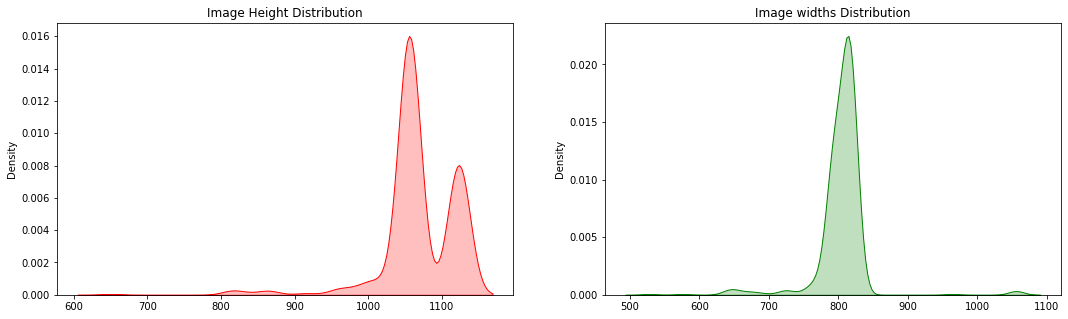

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(18,5))
sns.kdeplot(heights,shade=True, color="r", ax=ax[0])
ax[0].title.set_text("Image Height Distribution")

sns.kdeplot(widths,shade=True, color="green", ax=ax[1])
ax[1].title.set_text("Image widths Distribution")
plt.show()


**Observations**
- Most images have heights between 1000-1100 approximately and have widhts between 750-850.
 -The research paper suggests resizing all images to 1024x1024. From our observations we can also try out other dimensions like 800x800

### Table and Column widths

In [ ]:
col_widths = []
col_heights =[]
table_widths = []
table_heights =[]

def filter_tables(data,label):
  arr = json.loads(data)
  for x in arr:
    if x == "":
      return 
    if label == "table":
      table_heights.append(int(x["ymin"])-int(x["ymax"]))
      table_widths.append(int(x["xmax"])-int(x["xmin"]))
    else:
      col_heights.append(int(x["ymax"])-int(x["ymin"]))
      col_widths.append(int(x["xmax"])-int(x["xmin"]))

df["table_boxes"].apply(lambda x : filter_tables(x,"table"))
df["col_boxes"].apply(lambda x : filter_tables(x,"col"))
print()

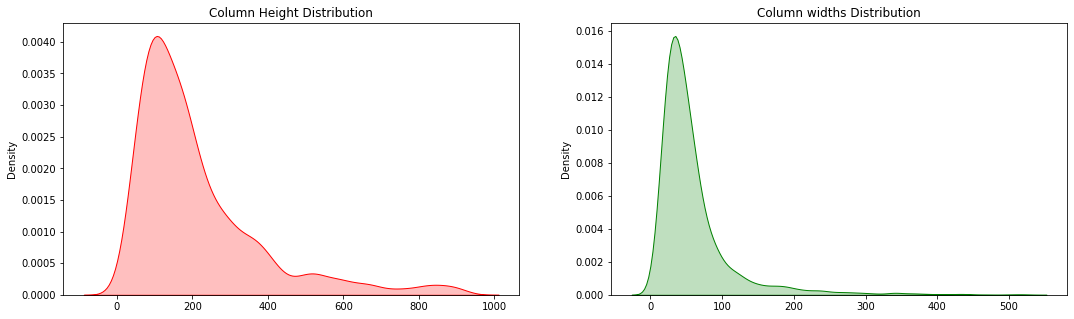

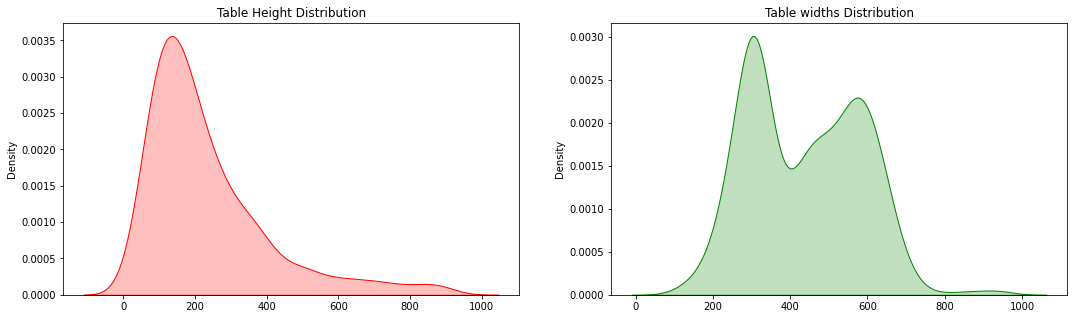

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(18,5))
sns.kdeplot(col_heights,shade=True, color="r", ax=ax[0])
ax[0].title.set_text("Column Height Distribution")

sns.kdeplot(col_widths,shade=True, color="green", ax=ax[1])
ax[1].title.set_text("Column widths Distribution")
plt.show()

fig, ax =plt.subplots(1,2,figsize=(18,5))
sns.kdeplot(table_heights,shade=True, color="r", ax=ax[0])
ax[0].title.set_text("Table Height Distribution")

sns.kdeplot(table_widths,shade=True, color="green", ax=ax[1])
ax[1].title.set_text("Table widths Distribution")
plt.show()


**Observations**
- Column Masks: We can observe the majority of the Columns have 
widhts 30-100 and heights around 20-400 
- Table Masks: We can observe the majority of the Columns have 
widhts around 200-700 and heights widths 20-500 
- As we can size average Table heights and Column heights are 
almost same as expected. Columns height is almost equal to Tables heights
- Similarly table widths are significatly larger than Columns, as many Columns constitute a table

### No of columns and tables in each table

In [ ]:
cols = []
tables =[]

def filter_count(row,label):
  arr = json.loads(row)
  if label == "col":
    cols.append(0 if isinstance(arr[0], str) else len(arr))
  else:
    tables.append(len(arr))

df["col_boxes"].apply(lambda x : filter_count(x,"col"))
df["table_boxes"].apply(lambda x : filter_count(x,"table"))
cols = Counter(cols)
tables = Counter(tables)
print()

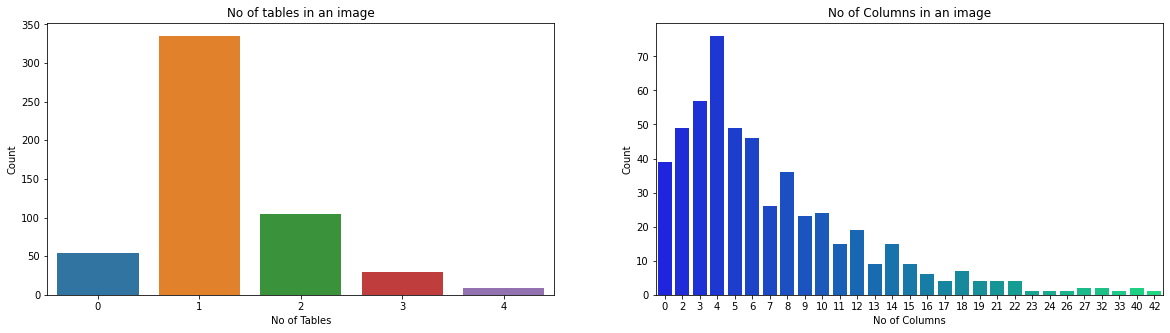

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.barplot(x=list(tables.keys()), y=list(tables.values()))
plt.xlabel("No of Tables")
plt.ylabel("Count")
plt.title("No of tables in an image")

plt.subplot(1,2,2)
sns.barplot(x=list(cols.keys()), y=list(cols.values()),palette="winter")
plt.xlabel("No of Columns")
plt.ylabel("Count")
plt.title("No of Columns in an image")
plt.show()

**Observations**

No of tables
- We can see that 50 tables have no tables, 340 tables have 1 table and very few images have more than 2 tables.
- Hence we find that majority images have only 1 table

No of columns
- Around 35 images have 0 columns.
- From the bar graph its clear than most tables have columns between 2-10. 75 images have 4 columns. Also, very few images have more than 15 columns.

### Images with No tables or No columns

In [ ]:
no_cols = []
no_tables =[]

def filter_count(row,label):
  arr = json.loads(row)
  if label == "col":
    cols.append(0 if isinstance(arr[0], str) else len(arr))
  else:
    tables.append(len(arr))

for idx, row in df.iterrows():
  id = row["id"]
  arr_col = json.loads(row["col_boxes"])
  arr_tab = json.loads(row["table_boxes"])

  if isinstance(arr_col[0],str):
    no_cols.append(id)
  if len(arr_tab) == 0:
    no_tables.append(id)


In [ ]:
print("No of Images with 0 tables: ",len(no_tables))
print("No of Images with 0 columns: ",len(no_cols))

No of Images with 0 tables:  54
No of Images with 0 columns:  39


#### Images with columns but no Tables

No of Images with columns but no Tables;  20


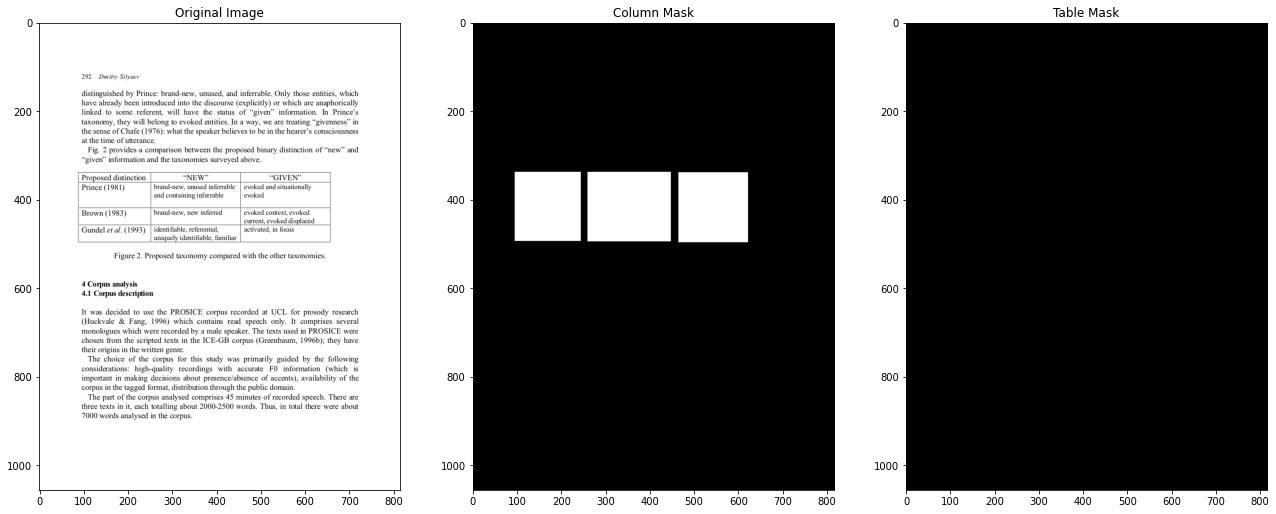

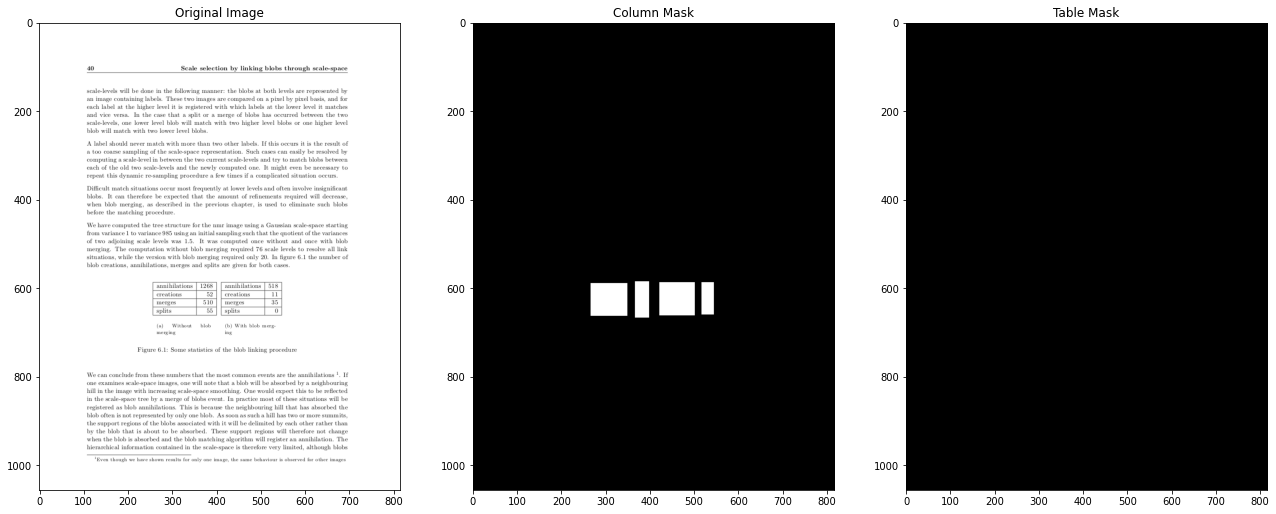

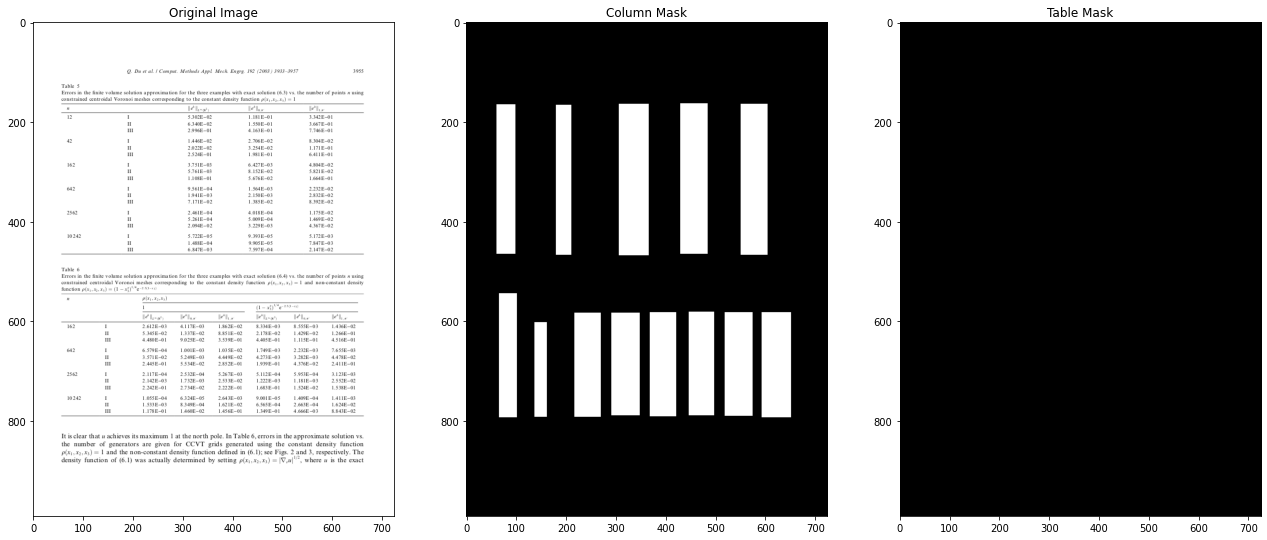

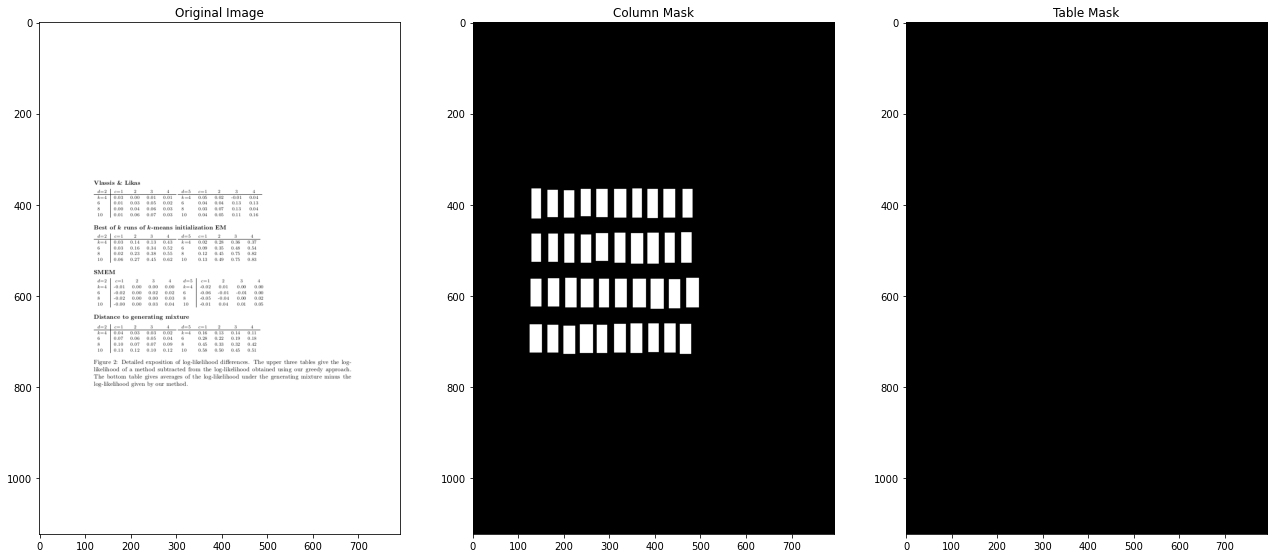

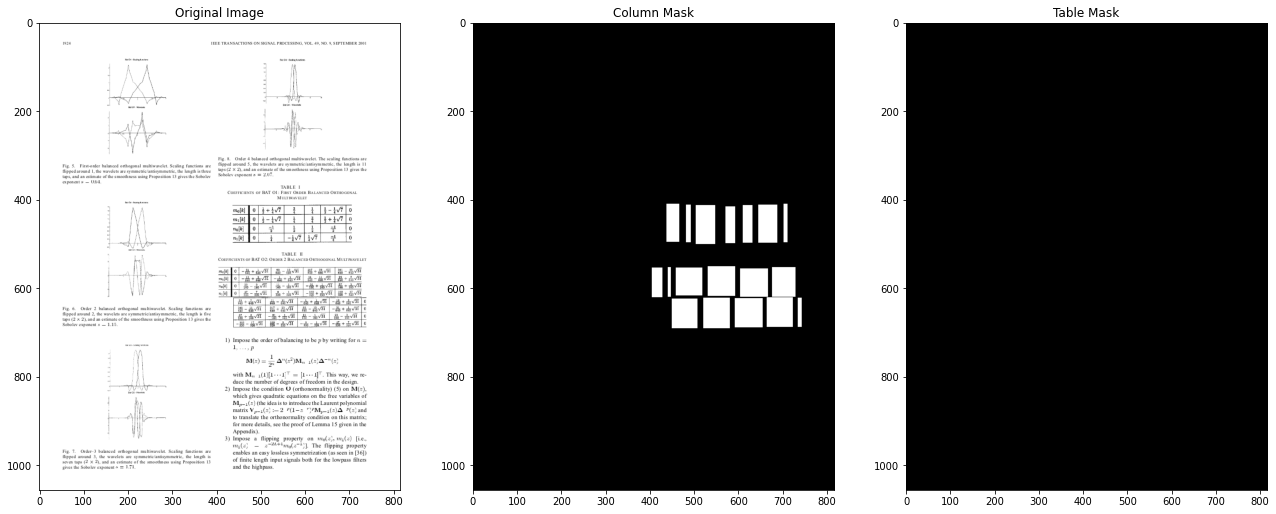

In [ ]:
img_with_cols_no_tables = list(set(no_tables)-set(no_cols))
print("No of Images with columns but no Tables; ",len(img_with_cols_no_tables))
for id in img_with_cols_no_tables[:5]:
  plot_images(id)

**Observations**
- We see than 20 images have columns but no tables. On inspecting these images we can see that this is an issue with the table_masks
- On looking at the original marmot dataset, we find that fr these images there are no table masks, but we have column masks in extended marmots dataset.
- To solve this we can choose 2 approaches
  1. Manually annotate these images
  2. Use the column masks to approximate the table masks
  As we have only 20 such images, we can opt to manually annotate these points using the tools we have available online.

#### Images with Tables but no columns

['10.1.1.7.2174_8', '10.1.1.160.669_3', '10.1.1.7.2174_3', '10.1.1.1.2010_5', '10.1.1.1.2107_9']
Images with Tables but no columns:  5


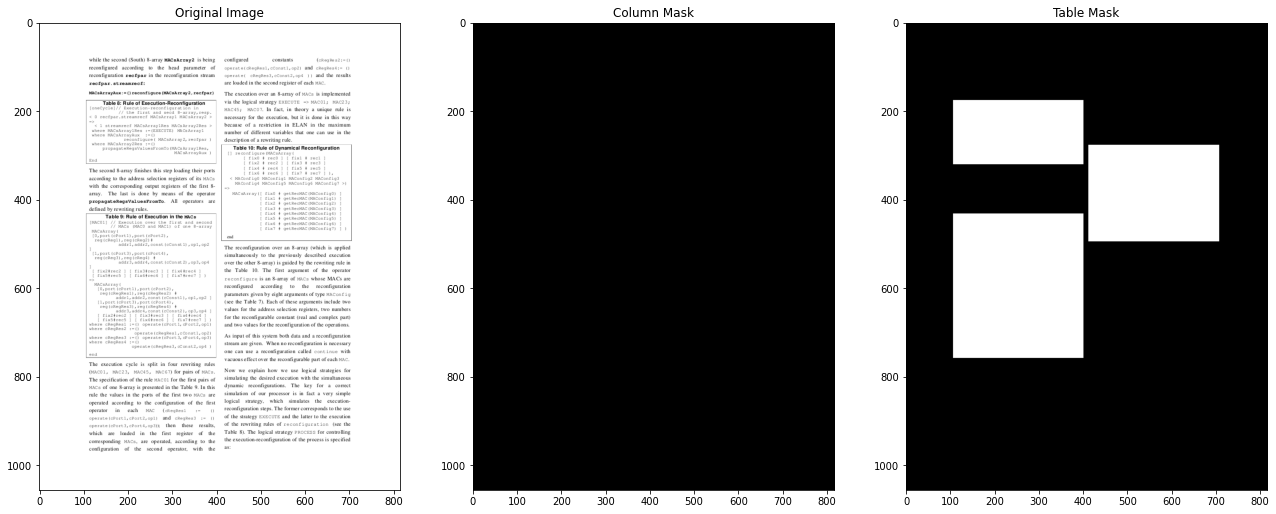

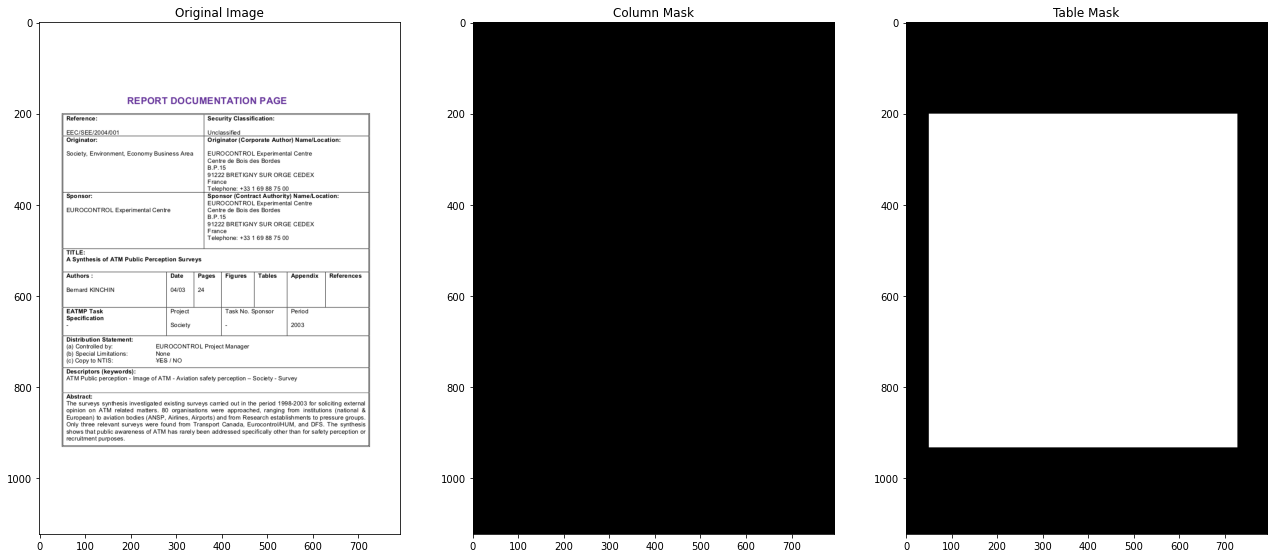

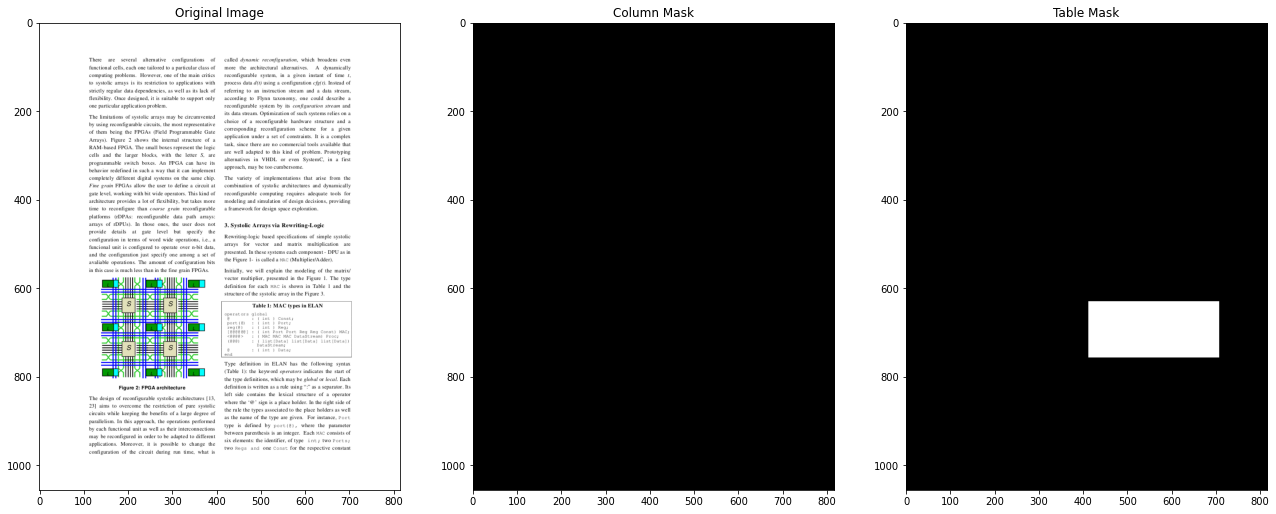

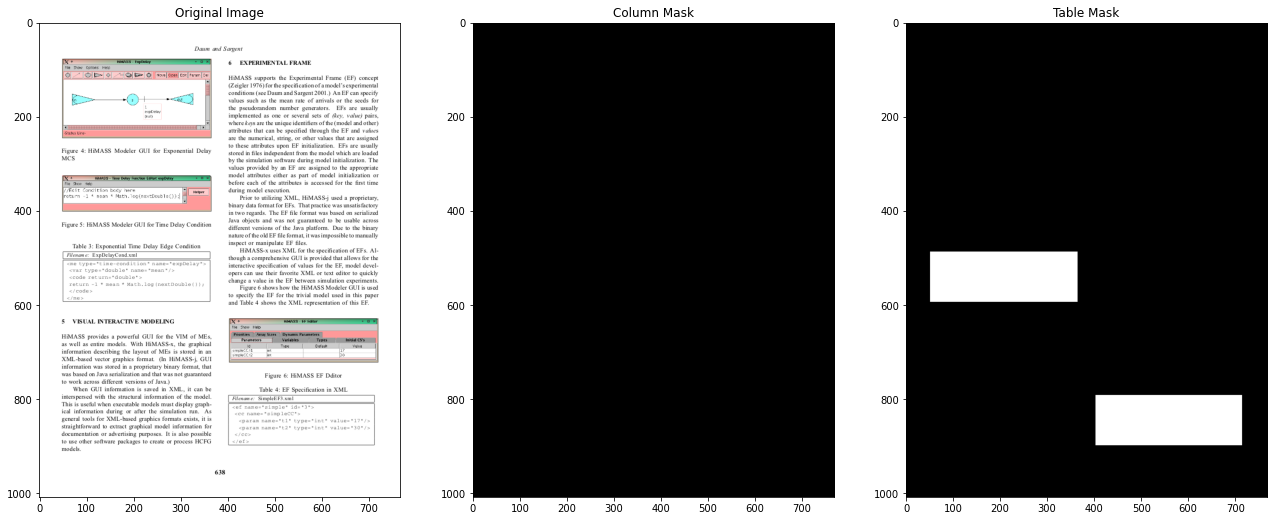

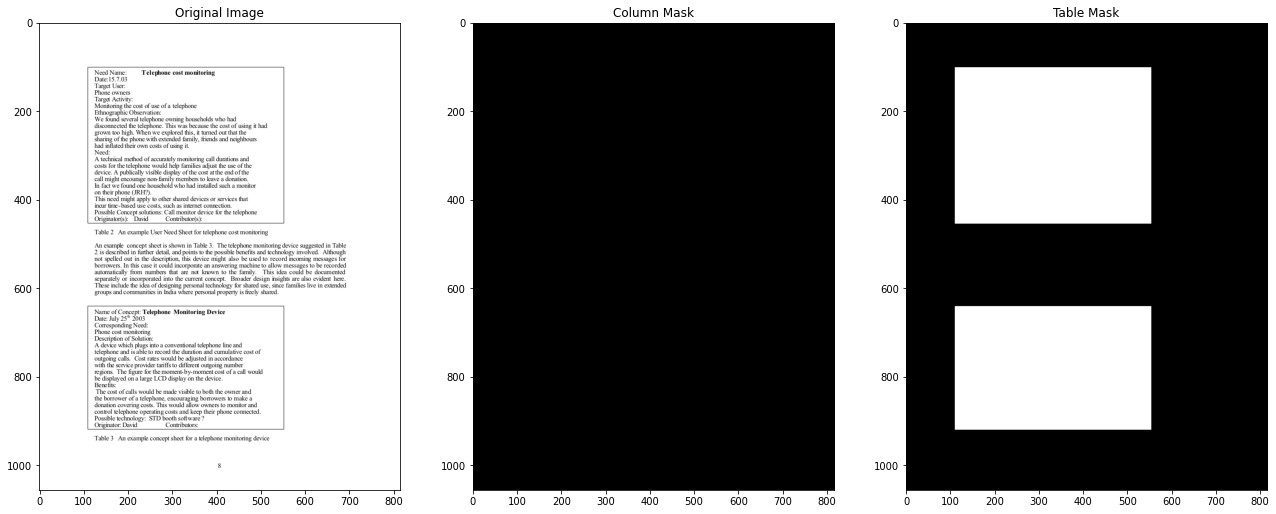

In [ ]:
img_with_no_cols = list(set(no_cols)-set(no_tables))
print("Images with Tables but no columns: ",len(img_with_no_cols))
for x in img_with_no_cols[:5]:
  plot_images(x)

**Observations**
- We see that 5 images have tables but no columns
- On manually inspecting these images, we find that these images are valid. As these images have tables but dont have any well structured row or columns

Images with no tables and columns:  34


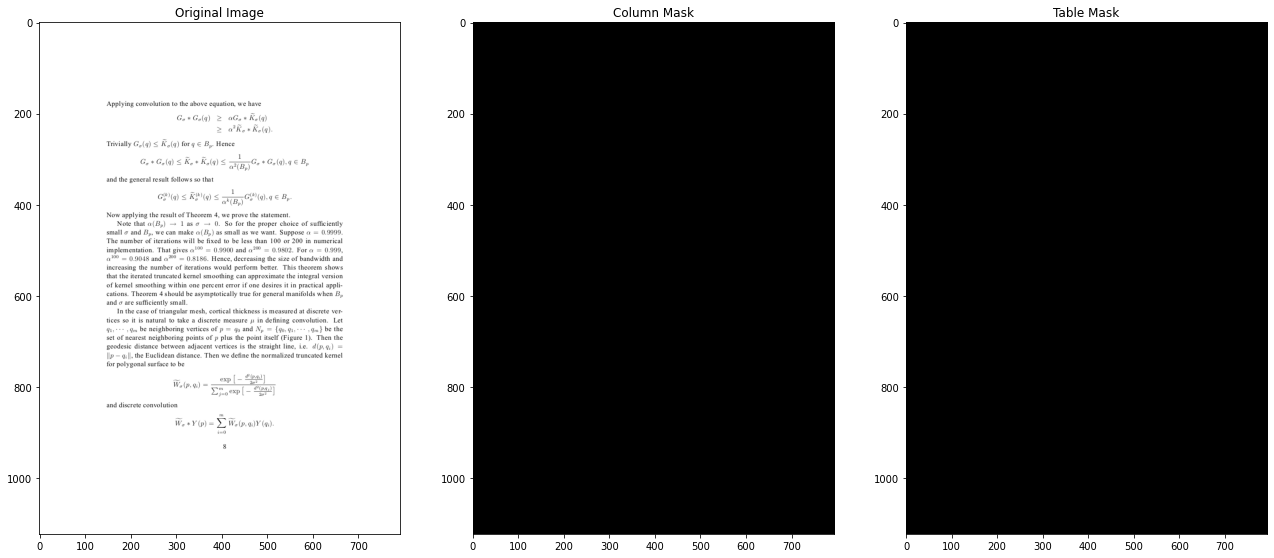

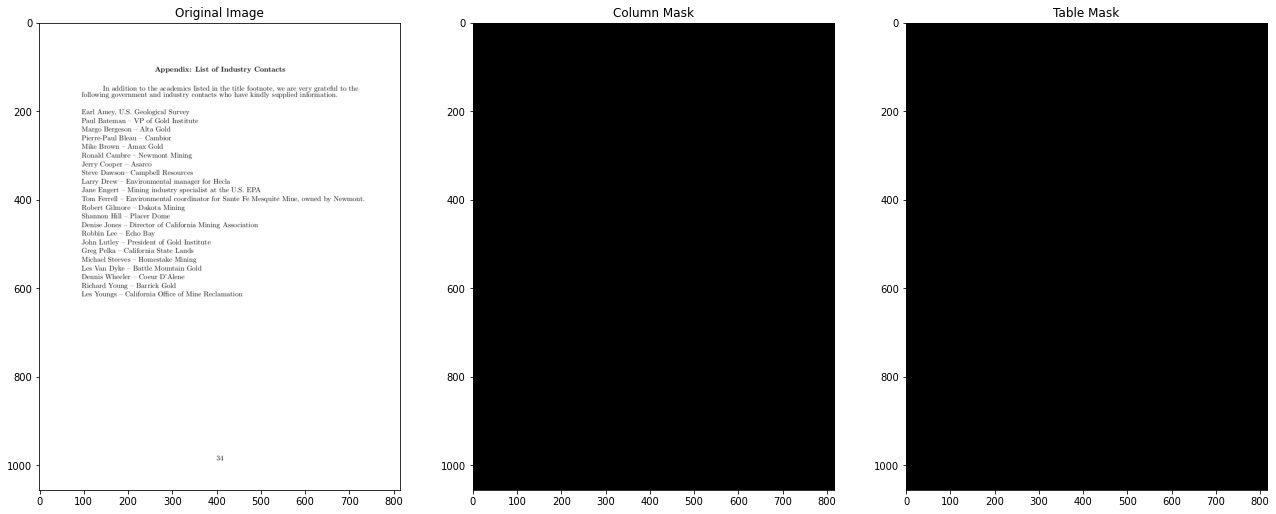

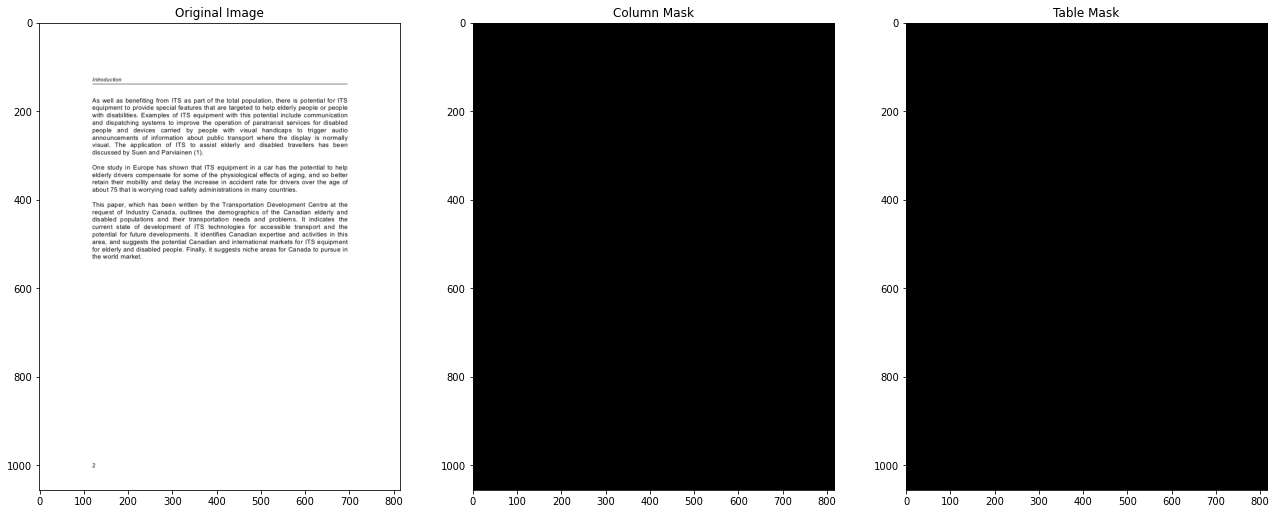

In [ ]:
no_tab_cols = set(no_cols).intersection(set(no_tables))
print("Images with no tables and columns: ",len(no_tab_cols))
for id in list(no_tab_cols)[:3]:
  plot_images(id)

**Observations**
- We find that 34 images have no tables or columns.
- Inspecting these images, we find that these tables indeed do not have any tables

In [ ]:
!jupyter nbconvert --to html "EDA_CS2.ipynb"

[NbConvertApp] Converting notebook EDA_CS2.ipynb to html
[NbConvertApp] Writing 3354787 bytes to EDA_CS2.html


# DataLoader

In [ ]:
df = pd.read_csv("final_dataset/marmot.csv")
df_train, df_test = train_test_split(df, test_size=0.1, random_state=10)
df.head(1)

,Unnamed: 0,id,col_boxes,table_boxes,dimensions,img_path,col_mask_path,table_mask_path
0,0,10.1.1.160.686_7,"[{""xmin"": ""61"", ""ymin"": ""118"", ""xmax"": ""126"", ...","[{""xmin"": 64, ""ymin"": 247, ""xmax"": 625, ""ymax""...","{""height"": 957, ""width"": 720}",final_dataset/images10.1.1.160.686_7.bmp,final_dataset/col_masks/10.1.1.160.686_7.bmp,final_dataset/table_masks/10.1.1.160.686_7.bmp


In [ ]:
IMG_SIZE = 512
class Dataset:
  def __init__(self,img_ids):
    self.img_ids = img_ids
    # print("INIT DATASET: ",len(img_ids))
    self.img_path = "final_dataset/images/"
    self.col_mask_path = "final_dataset/col_masks/"
    self.table_mask_path = "final_dataset/table_masks/"
  
  def __getitem__(self, i):
    id = self.img_ids[i]+".bmp"
    # read data
    image = load_img(self.img_path+id,target_size=(IMG_SIZE,IMG_SIZE), color_mode="rgb")
    # image = np.expand_dims(image,2)
    table_mask = load_img(self.table_mask_path+id,target_size=(IMG_SIZE,IMG_SIZE), color_mode="grayscale")
    table_mask = np.expand_dims(table_mask,2)
    table_mask = np.where(np.array(table_mask)==255,1,0)
    col_mask = load_img(self.col_mask_path+id,target_size=(IMG_SIZE,IMG_SIZE), color_mode="grayscale")
    col_mask = np.expand_dims(col_mask,2)
    col_mask = np.where(np.array(col_mask)==255,1,0)

    # return image, np.dstack((table_mask[:,:,0], col_mask[:,:,0]))
    # return image.astype(np.float32), np.expand_dims(table_mask[:,:,0], axis=-1).astype(int)
    return image, [table_mask, col_mask]

  def __len__(self):
        return len(self.img_ids)

In [ ]:
class Dataloder(tf.keras.utils.Sequence):
  def __init__(self, dataset, batch_size=1, shuffle=False):
    self.dataset = dataset
    # print("INIT: ",len(dataset))
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.indexes = np.arange(len(dataset))
  
  def __getitem__(self, i):
    # collect batch data
    start = i * self.batch_size
    stop = (i + 1) * self.batch_size
    data = []
    for j in range(start, stop):
        data.append(self.dataset[j])
    images, masks = [np.stack(samples, axis=0) for samples in zip(*data)]
    
    table_masks, col_masks= [], []
    for i in range(0,self.batch_size):
      table_masks.append(masks[i][0])
      col_masks.append(masks[i][1])
    
    table_masks = np.array(table_masks)
    col_masks = np.array(col_masks)

    return images, {"col_decoder":col_masks, "table_decoder":table_masks}
        
  def __len__(self):
    return len(self.indexes) // self.batch_size
        
  def on_epoch_end(self):
    if self.shuffle:
      self.indexes = np.random.permutation(self.indexes)


In [ ]:
train_dataset = Dataset(df_train["id"].values)
BATCH_SIZE=4
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print("Final dataset: ",len(train_dataloader))


Final dataset:  119


Res:  (4, 512, 512, 3)


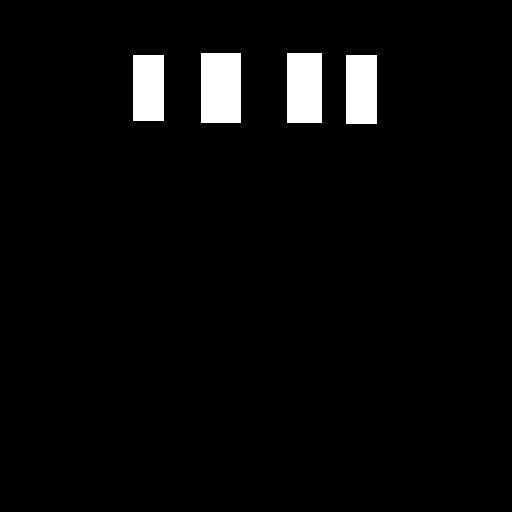

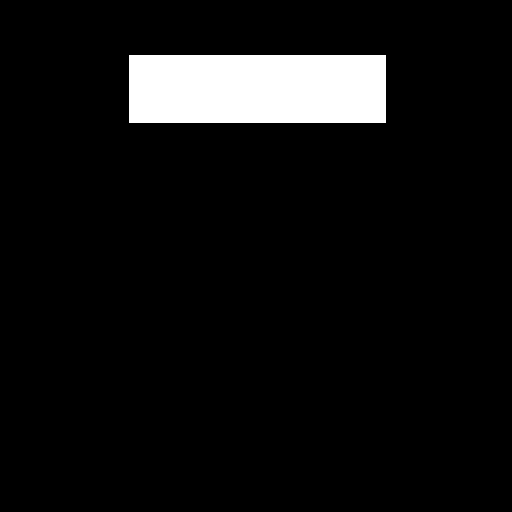

In [ ]:
print("Res: ",train_dataloader[0][0].shape)
# print("Res: ",train_dataloader[0][1][0][0].shape)
# print("Res: ",train_dataloader[0][1][0][1].shape)
# print("Res: ",train_dataloader[0][1][1].shape)
cv2_imshow(np.where(train_dataloader[0][1]["col_decoder"][0]==1,255,0))
cv2_imshow(np.where(train_dataloader[0][1]["table_decoder"][0]==1,255,0))

In [ ]:
# cv2_imshow(train_dataloader[0][0][0])
# cv2_imshow(train_dataloader[0][0][0])
# cv2_imshow(train_dataloader[0][0][0])
cv2_imshow(np.where(train_dataloader[0][0][2]==1,255,0))

# DataLoader

In [ ]:
df = pd.read_csv("final_dataset/marmot.csv")
df_train, df_test = train_test_split(df, test_size=0.1, random_state=10)
df.head(1)

,Unnamed: 0,id,col_boxes,table_boxes,dimensions,img_path,col_mask_path,table_mask_path
0,0,10.1.1.160.686_7,"[{""xmin"": ""61"", ""ymin"": ""118"", ""xmax"": ""126"", ...","[{""xmin"": 64, ""ymin"": 247, ""xmax"": 625, ""ymax""...","{""height"": 957, ""width"": 720}",final_dataset/images10.1.1.160.686_7.bmp,final_dataset/col_masks/10.1.1.160.686_7.bmp,final_dataset/table_masks/10.1.1.160.686_7.bmp


In [ ]:
IMG_SIZE = 512
class Dataset:
  def __init__(self,img_ids):
    self.img_ids = img_ids
    # print("INIT DATASET: ",len(img_ids))
    self.img_path = "final_dataset/images/"
    self.col_mask_path = "final_dataset/col_masks/"
    self.table_mask_path = "final_dataset/table_masks/"
  
  def __getitem__(self, i):
    id = self.img_ids[i]+".bmp"
    # read data
    image = load_img(self.img_path+id,target_size=(IMG_SIZE,IMG_SIZE), color_mode="rgb")
    # image = np.expand_dims(image,2)
    table_mask = load_img(self.table_mask_path+id,target_size=(IMG_SIZE,IMG_SIZE), color_mode="grayscale")
    table_mask = np.expand_dims(table_mask,2)
    table_mask = np.where(np.array(table_mask)==255,1,0)
    col_mask = load_img(self.col_mask_path+id,target_size=(IMG_SIZE,IMG_SIZE), color_mode="grayscale")
    col_mask = np.expand_dims(col_mask,2)
    col_mask = np.where(np.array(col_mask)==255,1,0)

    # return image, np.dstack((table_mask[:,:,0], col_mask[:,:,0]))
    # return image.astype(np.float32), np.expand_dims(table_mask[:,:,0], axis=-1).astype(int)
    return image, [table_mask, col_mask]

  def __len__(self):
        return len(self.img_ids)

In [ ]:
class Dataloder(tf.keras.utils.Sequence):
  def __init__(self, dataset, batch_size=1, shuffle=False):
    self.dataset = dataset
    # print("INIT: ",len(dataset))
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.indexes = np.arange(len(dataset))
  
  def __getitem__(self, i):
    # collect batch data
    start = i * self.batch_size
    stop = (i + 1) * self.batch_size
    data = []
    for j in range(start, stop):
        data.append(self.dataset[j])
    images, masks = [np.stack(samples, axis=0) for samples in zip(*data)]
    
    table_masks, col_masks= [], []
    for i in range(0,self.batch_size):
      table_masks.append(masks[i][0])
      col_masks.append(masks[i][1])
    
    table_masks = np.array(table_masks)
    col_masks = np.array(col_masks)

    return images, {"col_decoder":col_masks, "table_decoder":table_masks}
        
  def __len__(self):
    return len(self.indexes) // self.batch_size
        
  def on_epoch_end(self):
    if self.shuffle:
      self.indexes = np.random.permutation(self.indexes)


In [ ]:
train_dataset = Dataset(df_train["id"].values)
BATCH_SIZE=2
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print("Final dataset: ",len(train_dataloader))


Final dataset:  239


In [ ]:
print("Res: ",train_dataloader[0][0].shape)
# print("Res: ",train_dataloader[0][1][0][0].shape)
# print("Res: ",train_dataloader[0][1][0][1].shape)
# print("Res: ",train_dataloader[0][1][1].shape)
# cv2_imshow(np.where(train_dataloader[0][1]["col_decoder"][0]==1,255,0))
# cv2_imshow(np.where(train_dataloader[0][1]["table_decoder"][0]==1,255,0))

Res:  (2, 512, 512, 3)


In [ ]:
# cv2_imshow(train_dataloader[0][0][0])
# cv2_imshow(train_dataloader[0][0][0])
# cv2_imshow(train_dataloader[0][0][0])
cv2.imwrite('demo.jpg', train_dataloader[0][0][0])
# cv2_imshow(np.where(train_dataloader[0][0][2]==1,255,0))

True

# MODEL PLAYGROUND

In [ ]:
input = Input((1024,1024,1))
c1 = Conv2D(64,kernel_size=(1,1),padding='same')(input)
c2 = Conv2D(64,kernel_size=(1,1),padding='same')(c1)
c3 = Conv2D(32,kernel_size=(1,1),padding='same')(c2)
c4 = Conv2D(32,kernel_size=(1,1),padding='same')(c3)
# res = tf.squeeze(tf.stack([o1, o2],axis=-1))
res = Conv2D(2,kernel_size=(1,1),padding='same')(c4)

In [ ]:
# model = Model(inputs=input, outputs = [o1,o2,res])
model = Model(inputs=input, outputs = res)
model.summary()

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 1024, 1024, 1)]   0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 1024, 1024, 64)    128       
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 1024, 1024, 64)    4160      
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 1024, 1024, 32)    2080      
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 1024, 1024, 32)    1056      
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 1024, 1024, 2)     66        
Total params: 7,490
Trainable params: 7,490
Non-trainable params: 0
________________________________________________________

In [ ]:
IMAGE_SIZE = 256
# inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="input_image")
# encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(2, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model
model = model()

In [ ]:
LR = 1e-4
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam')

In [ ]:
model.fit_generator(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=20
)

Epoch 1/20
  1/133 [..............................] - ETA: 14s - loss: 0.0108

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


133/133 [==============================] - 7s 55ms/step - loss: 0.0159
Epoch 2/20
133/133 [==============================] - 7s 55ms/step - loss: 0.0151
Epoch 3/20
133/133 [==============================] - 8s 56ms/step - loss: 0.0172
Epoch 4/20
133/133 [==============================] - 8s 57ms/step - loss: 0.0199
Epoch 5/20
133/133 [==============================] - 8s 57ms/step - loss: 0.0255
Epoch 6/20
133/133 [==============================] - 8s 57ms/step - loss: 0.0738
Epoch 7/20
133/133 [==============================] - 7s 56ms/step - loss: 0.0416
Epoch 8/20
133/133 [==============================] - 7s 56ms/step - loss: 0.0225
Epoch 9/20
133/133 [==============================] - 7s 56ms/step - loss: 0.0165
Epoch 10/20
133/133 [==============================] - 7s 56ms/step - loss: 0.0136
Epoch 11/20
133/133 [==============================] - 7s 56ms/step - loss: 0.0120
Epoch 12/20
133/133 [==============================] - 7s 56ms/step - loss: 0.0123
Epoch 13/20
133/133 [===

(1, 256, 256, 3)
(256, 256, 2)
(256, 256, 2)
(256, 256)
(256, 256, 1)
Counter({0: 62044, 1: 3492})


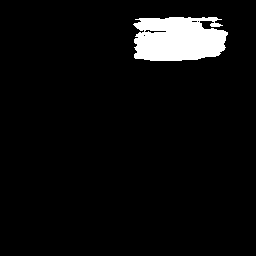

In [ ]:
a = np.array([train_dataloader[5][0][3]])
print(a.shape)
res = model.predict(a)
print(res[0].shape)
res = res[0]
plot_res(res)

In [ ]:
def plot_res(img):
  print(img.shape)
  img = np.argmax(img, axis=-1)
  print(img.shape)
  img = np.expand_dims(img, axis=-1)
  print(img.shape)
  print(Counter(img.ravel()))
  cv2_imshow(np.where(img==1,255,0))

# Real Model

In [ ]:
def plot_res(img):
  print(img.shape)
  img = np.argmax(img, axis=-1)
  print(img.shape)
  img = np.expand_dims(img, axis=-1)
  print(img.shape)
  print(Counter(img.ravel()))
  cv2_imshow(np.where(img==1,255,0))

In [ ]:
from tensorflow.keras.applications import VGG19
tf.keras.backend.set_image_data_format('channels_last')


In [ ]:
class TableBranch(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__(name="col_decoder")
    self.conv1 = Conv2D(filters =256,kernel_size = (1, 1), activation = 'relu')
    self.upsample1 = UpSampling2D(size=(2, 2))
    self.upsample2 = UpSampling2D(size=(2, 2))
    self.upsample3 = UpSampling2D(size=(2,2))
    self.upsample4 = UpSampling2D(size=(2,2))
    self.convtraspose = Conv2DTranspose(2,kernel_size=(3,3),strides=2,padding='same')
  
  def call(self, input):
    input, pool4, pool3 = input[0],input[1], input[2]
    conv_1 = self.conv1(input)
    up_sample1 = self.upsample1(conv_1)
    concat_1 = Concatenate()([pool4,up_sample1])

    up_sample2 = self.upsample2(concat_1)
    concat_2 = Concatenate()([pool3,up_sample2])

    up_sample3 = self.upsample3(concat_2)
    up_sample4 = self.upsample4(up_sample3)
    final = self.convtraspose(up_sample4)
    return final

class ColumnBranch(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__(name="table_decoder")
    self.conv1 = Conv2D(filters =256,kernel_size = (1, 1), activation = 'relu')
    self.conv2 = Conv2D(filters =256,kernel_size = (1, 1), activation = 'relu')
    self.drop1 = Dropout(0.8)
    self.upsample1 = UpSampling2D(size=(2, 2))
    self.upsample2 = UpSampling2D(size=(2, 2))
    self.upsample3 = UpSampling2D(size=(2,2))
    self.upsample4 = UpSampling2D(size=(2,2))
    self.convtraspose = Conv2DTranspose(2,kernel_size=(3,3),strides=2,padding='same')
  
  def call(self, input):
    input, pool4, pool3 = input[0],input[1], input[2]
    conv_1 = self.conv1(input)
    dropout = self.drop1(conv_1)
    conv_2 = self.conv2(dropout)

    up_sample1 = self.upsample1(conv_1)
    concat_1 = Concatenate()([pool4,up_sample1])

    up_sample2 = self.upsample2(concat_1)
    concat_2 = Concatenate()([pool3,up_sample2])

    up_sample3 = self.upsample3(concat_2)
    up_sample4 = self.upsample4(up_sample3)
    final = self.convtraspose(up_sample4)
    return final

In [ ]:
input_layer = Input((IMG_SIZE,IMG_SIZE,3),name="Input_Layer")
vgg_19= VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=input_layer,
    pooling=None, classes=1000
)
pool_4_op = vgg_19.get_layer("block4_pool").output
pool_3_op = vgg_19.get_layer("block3_pool").output
x = Conv2D(512, (1,1), activation='relu',name="block_6_conv_1")(vgg_19.output)
x = Dropout(0.8)(x)
x = Conv2D(512, (1,1), activation='relu',name="block_6_conv_2")(x)
x = Dropout(0.8)(x)

table_output = TableBranch()([x,pool_4_op,pool_3_op])
column_output = ColumnBranch()([x,pool_4_op,pool_3_op])
model = Model(inputs=input_layer, outputs=[table_output,column_output])
# model.summary()

80150528/80134624 [==============================] - 3s 0us/step


In [ ]:
# tf.keras.utils.plot_model(model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 1792        Input_Layer[0][0]                
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 256, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [ ]:
opt = tf.keras.optimizers.Adam(0.01)


losses = {
    "table_decoder":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    "col_decoder": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
}
model.compile(loss=losses, optimizer=tf.keras.optimizers.Adam(0.001))
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam')

In [ ]:
model.load_weights("/content/drive/MyDrive/Datasets/CS2//CS2_Combined_41_0020.hdf5")

In [ ]:
#Model checkpoint callback
file_path = "models/CS2_Combined_61_{epoch:04d}.hdf5"

cp_callback= tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,
    verbose=1,
    save_weights_only=True,
    period=5)

model.fit(
    train_dataloader,
    steps_per_epoch = TRAIN_STEPS_PER_EPOCH,
    epochs=10,
    callbacks=[cp_callback]
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


119/119 [==============================] - 197s 2s/step - loss: 0.2032 - col_decoder_loss: 0.1057 - table_decoder_loss: 0.0975
Epoch 2/10
119/119 [==============================] - 194s 2s/step - loss: 0.1906 - col_decoder_loss: 0.0982 - table_decoder_loss: 0.0924
Epoch 3/10
119/119 [==============================] - 194s 2s/step - loss: 0.1825 - col_decoder_loss: 0.0971 - table_decoder_loss: 0.0854
Epoch 4/10
119/119 [==============================] - 194s 2s/step - loss: 0.1784 - col_decoder_loss: 0.0956 - table_decoder_loss: 0.0828
Epoch 5/10
119/119 [==============================] - 194s 2s/step - loss: 0.2039 - col_decoder_loss: 0.1028 - table_decoder_loss: 0.1011

Epoch 00005: saving model to models/CS2_Combined_61_0005.hdf5
Epoch 6/10
119/119 [==============================] - 194s 2s/step - loss: 0.2498 - col_decoder_loss: 0.1240 - table_decoder_loss: 0.1257
Epoch 7/10
119/119 [==============================] - 194s 2s/step - loss: 0.2084 - col_decoder_loss: 0.1058 - table_dec

In [ ]:
# model.load_weights("/content/CS2_Table_50_0030.hdf5")
!cp "/content/models/CS2_Combined_61_0030.hdf5" "/content/drive/MyDrive/Datasets/CS2/"

(512, 512, 2)
(512, 512)
(512, 512, 1)
Counter({0: 237674, 1: 24470})


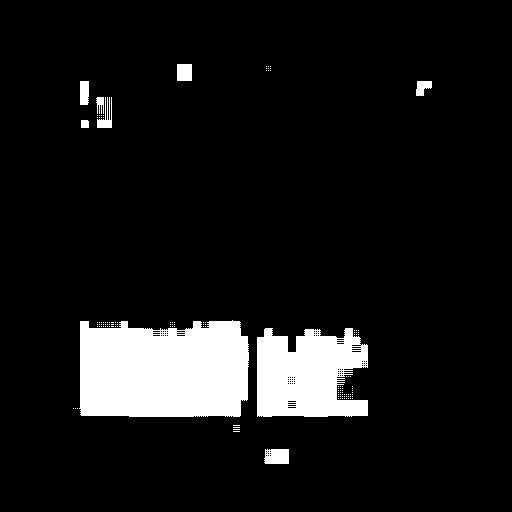

(512, 512, 2)
(512, 512)
(512, 512, 1)
Counter({0: 226270, 1: 35874})


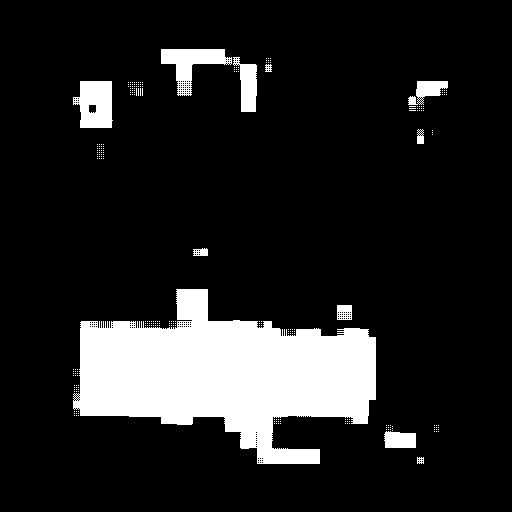

In [ ]:
a = np.array([train_dataloader[4][0][0]])
res1, res2 = model.predict(a)
res1 =res1[0]
res2= res2[0]
plot_res(res1)
plot_res(res2)

In [ ]:
def plot_res(img):
  print(img.shape)
  img = np.argmax(img, axis=-1)
  print(img.shape)
  img = np.expand_dims(img, axis=-1)
  print(img.shape)
  print(Counter(img.ravel()))
  cv2_imshow(np.where(img==1,255,0))

# SECOND MODEL

In [ ]:
#input size for all image should be 1024 * 1024 with three channels
inputShape = (IMG_SIZE, IMG_SIZE, 3)
inputs = Input(shape=inputShape, name='input')

#importing  pre trained VGG19 model till to bottle neck
vgg_19=tf.keras.applications.VGG19(input_tensor=inputs,include_top=False, weights='imagenet', pooling=None, classes=1000)

#addding 2 (1 * 1) convolutional layers followed by dropot eith 80%
x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv1')(vgg_19.output)
x = Dropout(0.8, name='block6_dropout1')(x)
x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv2')(x)
x = Dropout(0.8, name = 'block6_dropout2')(x)


#taking 3rd and 4th maxpool layer from vgg_19 for decoders
block3_pool=vgg_19.get_layer('block3_pool').output
block4_pool=vgg_19.get_layer('block4_pool').output

In [ ]:

class table_decoder(tf.keras.layers.Layer):
    def __init__(self, name="table_mask"):
        super().__init__(name=name)
        self.conv1 = Conv2D(filters =512,kernel_size = (1, 1), activation = 'relu')
        self.upsample1 = UpSampling2D(size=(2, 2))
        self.upsample2 = UpSampling2D(size=(2, 2))
        self.upsample3 = UpSampling2D(size=(2,2))
        self.upsample4 = UpSampling2D(size=(2,2))
        self.convtraspose = tf.keras.layers.Conv2DTranspose(2, 3, strides=2,padding='same')

        
    def call(self, X):
      input , pool_3, pool_4 = X[0] , X[1], X[2]


      result = self.conv1(input)
      result = self.upsample1(result)
      result = Concatenate()([result,pool_4])
      result = self.upsample2(result)
      result = Concatenate()([result,pool_3])
      result = self.upsample3(result)
      result = self.upsample4(result)
      result = self.convtraspose(result)

      return result

class column_decoder(tf.keras.layers.Layer):
    def __init__(self, name="column_mask"):
        super().__init__(name=name)
        self.conv1 = Conv2D(filters =512,kernel_size = (1, 1), activation = 'relu')
        self.drop = Dropout(0.8)
        self.conv2 = Conv2D(filters =512,kernel_size = (1, 1), activation = 'relu')
        self.upsample1 = UpSampling2D(size=(2, 2))
        self.upsample2 = UpSampling2D(size=(2, 2))
        self.upsample3 = UpSampling2D(size=(2,2))
        self.upsample4 = UpSampling2D(size=(2,2))
        self.convtraspose = tf.keras.layers.Conv2DTranspose(2, 3, strides=2,padding='same', name='column_mask')
        
    def call(self, X):
      input , pool_3, pool_4 = X[0] , X[1], X[2]

      result = self.conv1(input)
      result = self.drop(result)
      result = self.conv2(result)
      result = self.upsample1(result)
      result = Concatenate()([result,pool_4])
      result = self.upsample2(result)
      result = Concatenate()([result,pool_3])
      result = self.upsample3(result)
      result = self.upsample4(result)
      result = self.convtraspose(result)
      return result

In [ ]:
encoder_result = [x,block3_pool,block4_pool]

Table_Decoder = table_decoder()
Column_Decoder = column_decoder()

output1 = Table_Decoder(encoder_result)
# output2 = Column_Decoder(encoder_result)

model1 = Model(inputs=inputs,outputs=[output1],name="tablenet")

In [ ]:
model1.summary()

Model: "tablenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input[0][0]                      
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [ ]:
# losses = {
#     "table_mask": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     "column_mask": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
# }
# lossWeights = {"table_mask": 1.0, "column_mask": 1.0}

losses = {
    "table_mask": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
}
lossWeights = {"table_mask": 1.0}


model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08),
              loss=losses,
              metrics=['accuracy'],
              loss_weights=lossWeights)

In [ ]:
model_history = model1.fit(train_dataloader, epochs=10)

Epoch 1/10
133/133 [==============================] - 90s 420ms/step - loss: 9.4405 - accuracy: 0.8401
Epoch 2/10
133/133 [==============================] - 56s 420ms/step - loss: 0.4329 - accuracy: 0.8557
Epoch 3/10
133/133 [==============================] - 56s 419ms/step - loss: 0.3453 - accuracy: 0.8614
Epoch 4/10
133/133 [==============================] - 56s 419ms/step - loss: 0.2810 - accuracy: 0.8643
Epoch 5/10
133/133 [==============================] - 56s 419ms/step - loss: 0.2640 - accuracy: 0.8633
Epoch 6/10
133/133 [==============================] - 56s 418ms/step - loss: 0.2452 - accuracy: 0.8591
Epoch 7/10
133/133 [==============================] - 56s 420ms/step - loss: 0.2251 - accuracy: 0.8601
Epoch 8/10
133/133 [==============================] - 56s 419ms/step - loss: 0.2351 - accuracy: 0.8549
Epoch 9/10
133/133 [==============================] - 56s 419ms/step - loss: 0.2048 - accuracy: 0.8567
Epoch 10/10
133/133 [==============================] - 56s 419ms/step - l

(1, 256, 256, 3)
(256, 256, 2)
(256, 256, 2)
(256, 256)
(256, 256, 1)
Counter({0: 60447, 1: 5089})


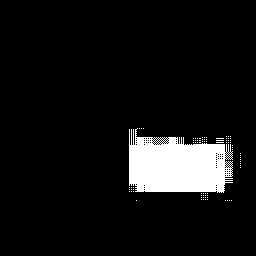

In [ ]:
def plot_res(img):
  print(img.shape)
  img = np.argmax(img, axis=-1)
  print(img.shape)
  img = np.expand_dims(img, axis=-1)
  print(img.shape)
  print(Counter(img.ravel()))
  cv2_imshow(np.where(img==1,255,0))

a = np.array([train_dataloader[12][0][3]])
print(a.shape)
res = model1.predict(a)
print(res[0].shape)
res = res[0]
plot_res(res)

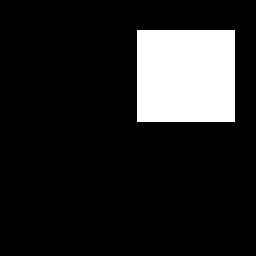

In [ ]:
cv2_imshow(np.where(train_dataloader[14][1][3]==1,255,0))